In [6]:
# %tensorflow_version 1.x magic

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *

# tf.compat.v1.enable_eager_execution()

In [7]:
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow_probability.python.layers import DenseVariational, DenseReparameterization, DenseFlipout, Convolution2DFlipout, Convolution2DReparameterization
from tensorflow_probability.python.layers import DistributionLambda

In [8]:
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

%matplotlib inline

print('TensorFlow version:', tf.__version__)
print('TensorFlow Probability version:', tfp.__version__)

TensorFlow version: 1.14.0
TensorFlow Probability version: 0.7.0


In [9]:
def neg_log_likelihood_with_logits(y_true, y_pred):
    y_pred_dist = tfp.distributions.Categorical(logits=y_pred)
    return -tf.reduce_mean(y_pred_dist.log_prob(tf.argmax(y_true, axis=-1)))

Loading MNIST dataset
X_train.shape = (60000, 28, 28, 1)
y_train.shape = (60000, 10)
X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000, 10)


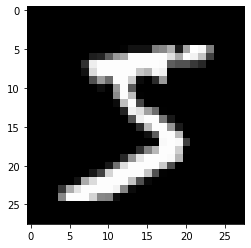

In [13]:
n_class = 10

batch_size = 128
n_epochs = 20
lr = 1e-3

print('Loading MNIST dataset')
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = np.expand_dims(X_train, -1)
n_train = X_train.shape[0]
X_test = np.expand_dims(X_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, n_class)
y_test = tf.keras.utils.to_categorical(y_test, n_class)

# Normalize data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

plt.imshow(X_train[0, :, :, 0], cmap='gist_gray')

In [14]:
def get_kernel_divergence_fn(train_size, w=1.0):
    def kernel_divergence_fn(q, p, _):  # need the third ignorable argument
        kernel_divergence = tfp.distributions.kl_divergence(q, p) / tf.cast(train_size, tf.float32)
        return w * kernel_divergence
    return kernel_divergence_fn

In [15]:
def add_kl_weight(layer, train_size, w_value=1.0):
    w = layer.add_weight(name=layer.name+'/kl_loss_weight', shape=(),initializer=tf.initializers.constant(w_value), trainable=False)
    layer.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w)
    return layer

In [16]:
def build_bayesian_bcnn_model(input_shape, train_size):
    model_in = Input(shape=input_shape)
    conv_1 = Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2,kernel_divergence_fn=None)
    conv_1 = add_kl_weight(conv_1, train_size)
    x = conv_1(model_in)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    conv_2 = Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2,kernel_divergence_fn=None)
    conv_2 = add_kl_weight(conv_2, train_size)
    x = conv_2(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    dense_1 = DenseFlipout(512, activation='relu',kernel_divergence_fn=None)
    dense_1 = add_kl_weight(dense_1, train_size)
    x = dense_1(x)
    dense_2 = DenseFlipout(10, activation=None,kernel_divergence_fn=None)
    dense_2 = add_kl_weight(dense_2, train_size)
    model_out = dense_2(x)  # logits
    model = Model(model_in, model_out)
    return model
    
bcnn_model = build_bayesian_bcnn_model(X_train.shape[1:], n_train)
bcnn_model.compile(loss=neg_log_likelihood_with_logits, optimizer=Adam(lr), metrics=['acc'],experimental_run_tf_function=False)
bcnn_model.summary()
hist = bcnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_split=0.1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_flipout (Conv2DFlipou (None, 14, 14, 32)        609       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 7, 7, 64)          36929     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 64)          0     

ValueError: Invalid argument "experimental_run_tf_function" passed to K.function with TensorFlow backend

In [9]:

n_mc_run = 100
med_prob_thres = 0.2

y_pred_logits_list = [bcnn_model.predict(X_test) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_test[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_test[idx_invalid]))

Number of recognizable samples: 9995
Unrecognizable samples: [1039 4289 6572 6651 9634]
Test accuracy on MNIST (recognizable samples): 0.9880940470235118
Test accuracy on MNIST (unrecognizable samples): 0.4


In [0]:

def plot_pred_hist(y_pred, n_class, n_mc_run, n_bins=30, med_prob_thres=0.2, n_subplot_rows=2, figsize=(25, 10)):
    bins = np.logspace(-n_bins, 0, n_bins+1)
    fig, ax = plt.subplots(n_subplot_rows, n_class // n_subplot_rows + 1, figsize=figsize)
    for i in range(n_subplot_rows):
        for j in range(n_class // n_subplot_rows + 1):
            idx = i * (n_class // n_subplot_rows + 1) + j
            if idx < n_class:
                ax[i, j].hist(y_pred[idx], bins)
                ax[i, j].set_xscale('log')
                ax[i, j].set_ylim([0, n_mc_run])
                ax[i, j].title.set_text("{} (median prob: {:.2f}) ({})".format(str(idx),np.median(y_pred[idx]),str(np.median(y_pred[idx]) >= med_prob_thres)))
            else:
                ax[i, j].axis('off')
    plt.show()

True label of the test sample 0: 7


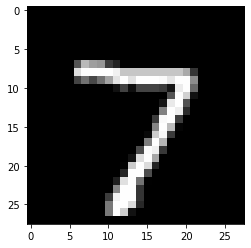

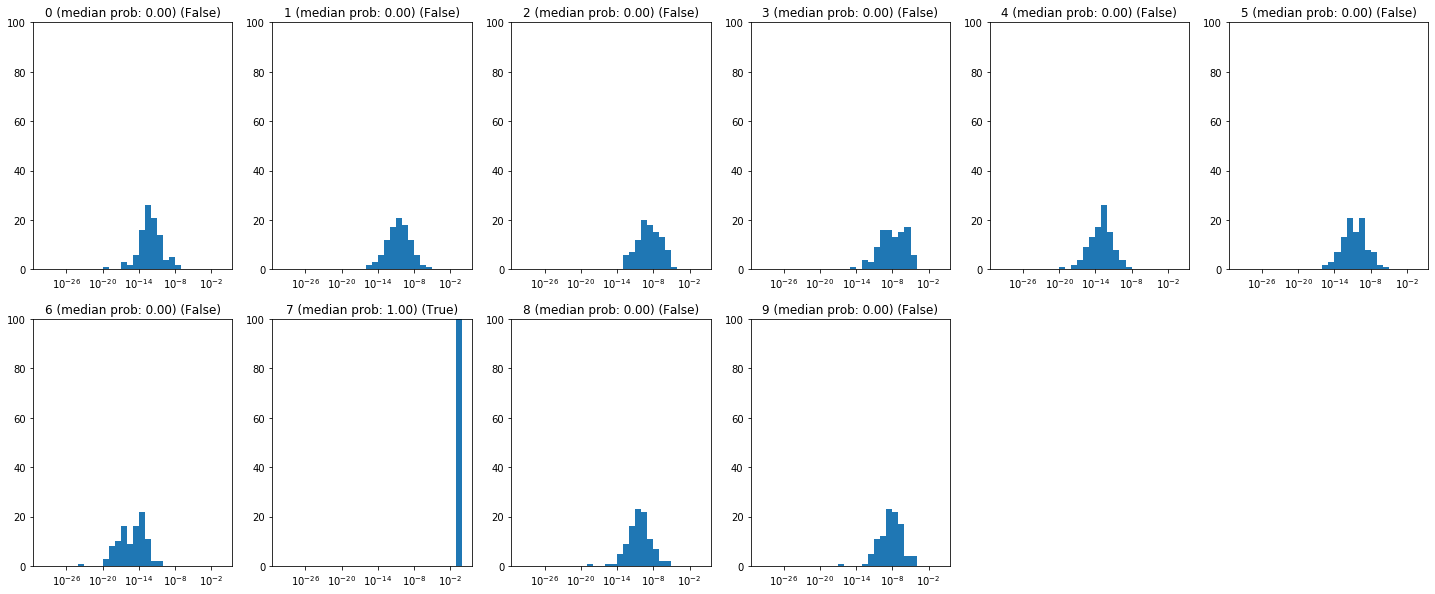

Predicted label of the test sample 0: 7


In [11]:

idx = 0
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")

True label of the test sample 1039: 7


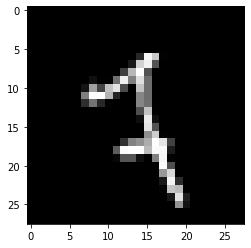

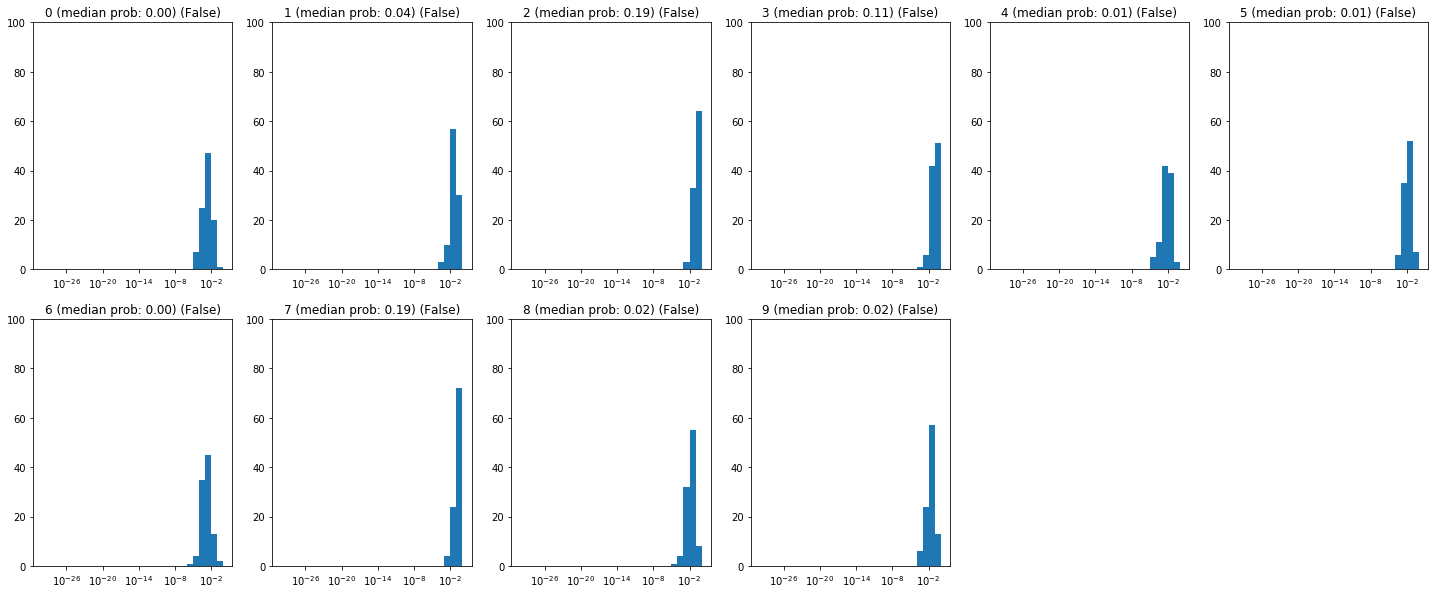

I don't know!


In [12]:
idx = 1039
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")

True label of the test sample 1331: 5


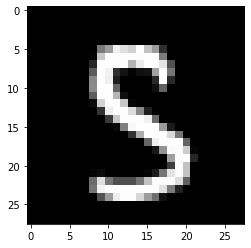

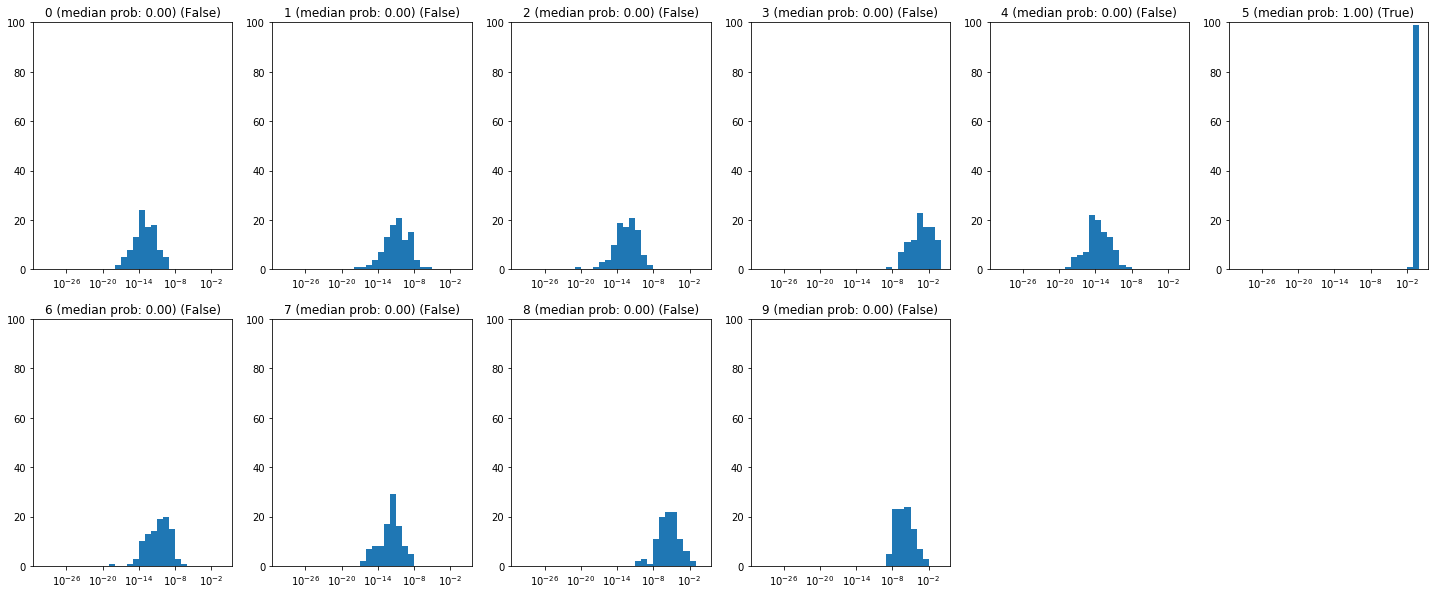

Predicted label of the test sample 1331: 5


In [16]:
idx = 1331
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")

True label of the test sample 4967: 9


NameError: name 'plot_pred_hist' is not defined

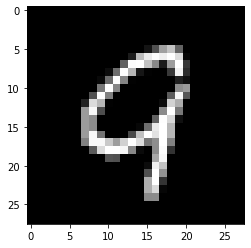

In [12]:
idx = 4967
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")